### '노화의 종말' 건강 서베이 결과로 기대수명 구하기 

- 로직 
  1. 응답자별 설문값 평균 점수 구하기 
  2. 응답자 전체 평균 점수를 정규분포로 근사하여 개인별 건강점수(스코어)를 계산한다. 
  3. 성-연령생명표에 응답자의 성-연령과 건강점수(스코어)를 조합하여 기대수명을 계산한다. 

- 설문지 : https://forms.gle/sAVeyiqSFSFsUEmN6

In [ ]:
import pandas as pd
import numpy as np
import io 
from scipy import stats  # 100% 분위수 구하기 : 정규표준화해서 누적확률밀도함수(cdf) 구하기 

# 한글 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib
%matplotlib inline
plt.style.use('ggplot')
  
import seaborn as sns

# 정규분포 만들기 
rv = stats.norm(0, 1)  # rv.cdf(0)  -> 0.5

### 성-연령 생존확률표 

출처 : 통계청 2019년 생명표 https://www.korea.kr/common/download.do?fileId=193234371

In [ ]:
male = """\
0 1 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100
0 100.0 99.7 99.6 99.6 99.6 99.4 99.2 99.0 98.6 98.1 97.5 96.3 94.5 91.9 88.3 82.9 74.9 61.7 42.9 22.4 7.6 1.3
1 0 100.0 99.9 99.9 99.8 99.7 99.5 99.3 98.9 98.4 97.7 96.6 94.8 92.2 88.5 83.2 75.1 61.9 43.0 22.5 7.6 1.4
5 0 0 100.0 100.0 99.9 99.8 99.6 99.3 99.0 98.5 97.8 96.7 94.9 92.3 88.6 83.2 75.1 62.0 43.1 22.5 7.6 1.4
10 0 0 0 100.0 100.0 99.8 99.6 99.4 99.0 98.5 97.8 96.7 94.9 92.3 88.6 83.3 75.2 62.0 43.1 22.5 7.6 1.4
15 0 0 0 0 100.0 99.9 99.7 99.4 99.1 98.6 97.9 96.7 94.9 92.3 88.7 83.3 75.2 62.0 43.1 22.5 7.6 1.4
20 0 0 0 0 0 100.0 99.8 99.5 99.2 98.7 98.0 96.9 95.1 92.5 88.8 83.4 75.3 62.1 43.2 22.6 7.6 1.4
25 0 0 0 0 0 0 100.0 99.7 99.4 98.9 98.2 97.1 95.3 92.6 89.0 83.6 75.5 62.2 43.2 22.6 7.6 1.4
30 0 0 0 0 0 0 0 100.0 99.7 99.2 98.5 97.3 95.5 92.9 89.2 83.8 75.6 62.4 43.4 22.7 7.6 1.4
35 0 0 0 0 0 0 0 0 100.0 99.5 98.8 97.7 95.8 93.2 89.5 84.1 75.9 62.6 43.5 22.7 7.7 1.4
40 0 0 0 0 0 0 0 0 0 100.0 99.3 98.1 96.3 93.7 89.9 84.5 76.3 62.9 43.7 22.8 7.7 1.4
45 0 0 0 0 0 0 0 0 0 0 100.0 98.8 97.0 94.3 90.6 85.1 76.8 63.4 44.0 23.0 7.8 1.4
50 0 0 0 0 0 0 0 0 0 0 0 100.0 98.1 95.4 91.7 86.1 77.7 64.1 44.6 23.3 7.8 1.4
55 0 0 0 0 0 0 0 0 0 0 0 0 100.0 97.3 93.4 87.7 79.2 65.3 45.4 23.7 8.0 1.4
60 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 96.0 90.2 81.5 67.2 46.7 24.4 8.2 1.5
65 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 93.9 84.8 69.9 48.6 25.4 8.6 1.5
70 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 90.3 74.4 51.7 27.0 9.1 1.6
75 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 82.5 57.3 29.9 10.1 1.8
80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 69.5 36.3 12.2 2.2
85 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 52.3 17.6 3.1
90 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 33.7 6.0
95 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 17.9
"""

female = """\
0 1 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100
0 100.0 99.8 99.7 99.7 99.6 99.5 99.4 99.3 99.0 98.7 98.4 97.8 97.1 96.2 94.8 92.7 88.8 81.0 66.3 43.4 19.3 4.8
1 0 100.0 99.9 99.9 99.9 99.8 99.6 99.5 99.3 99.0 98.6 98.1 97.4 96.4 95.1 92.9 89.0 81.2 66.4 43.5 19.4 4.8
5 0 0 100.0 100.0 99.9 99.8 99.7 99.6 99.3 99.0 98.7 98.1 97.4 96.5 95.1 92.9 89.1 81.3 66.5 43.5 19.4 4.8
10 0 0 0 100.0 100.0 99.9 99.7 99.6 99.4 99.1 98.7 98.2 97.5 96.5 95.1 93.0 89.1 81.3 66.5 43.5 19.4 4.8
15 0 0 0 0 100.0 99.9 99.8 99.6 99.4 99.1 98.7 98.2 97.5 96.5 95.2 93.0 89.1 81.3 66.5 43.5 19.4 4.8
20 0 0 0 0 0 100.0 99.9 99.7 99.5 99.2 98.8 98.3 97.6 96.6 95.3 93.1 89.2 81.4 66.6 43.6 19.4 4.8
25 0 0 0 0 0 0 100.0 99.8 99.6 99.3 99.0 98.4 97.7 96.7 95.4 93.2 89.3 81.5 66.6 43.6 19.5 4.8
30 0 0 0 0 0 0 0 100.0 99.8 99.5 99.1 98.6 97.9 96.9 95.5 93.4 89.5 81.6 66.7 43.7 19.5 4.8
35 0 0 0 0 0 0 0 0 100.0 99.7 99.3 98.8 98.1 97.1 95.8 93.6 89.7 81.8 66.9 43.8 19.5 4.8
40 0 0 0 0 0 0 0 0 0 100.0 99.6 99.1 98.4 97.4 96.0 93.8 89.9 82.1 67.1 43.9 19.6 4.8
45 0 0 0 0 0 0 0 0 0 0 100.0 99.5 98.8 97.8 96.4 94.2 90.3 82.4 67.4 44.1 19.7 4.8
50 0 0 0 0 0 0 0 0 0 0 0 100.0 99.3 98.3 96.9 94.7 90.8 82.8 67.7 44.3 19.8 4.9
55 0 0 0 0 0 0 0 0 0 0 0 0 100.0 99.0 97.6 95.4 91.4 83.4 68.2 44.6 19.9 4.9
60 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 98.6 96.3 92.3 84.3 68.9 45.1 20.1 5.0
65 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 97.7 93.6 85.4 69.9 45.7 20.4 5.0
70 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 95.8 87.4 71.5 46.8 20.9 5.1
75 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 91.3 74.6 48.8 21.8 5.4
80 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 81.8 53.5 23.9 5.9
85 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 65.5 29.2 7.2
90 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 44.6 11.0
95 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 100.0 24.6
"""

survival_male = pd.read_csv(io.StringIO(male), sep=' ')
survival_female = pd.read_csv(io.StringIO(female), sep=' ')

### 기대수명 예측 함수 

1. 해당 성별에 따라 성 연령표 선택
2. 해당 연령에 가장 근접한 나이 그룹을 찾는다. (5세 단위) 
3. 건강점수 순위에 따라 기대수명을 찾는다. 


In [ ]:
age_dic = {'male':survival_male, 'female':survival_female}

def min_diff_pos(arr, target):  # 최근접값 위치
  return np.abs(arr - target).argmin()

def pred_age(a, b, r, min_age):  # 보간율 반영
   adj_r = (a - r) / (a - b) 
   return min_age + adj_r * 5

def get_age(gender, age, r):   # 기대수명 예측
  age_near = min_diff_pos(np.array(age_dic[gender].index.values), age)
  ser = age_dic[gender].iloc[age_near]

  pos = min_diff_pos(ser.values, r)

  if r < ser[-1]:  
    res = 100 
  elif r >= ser[pos]:
    a = ser[pos-1]
    b = ser[pos]
    res = pred_age(a, b, r, int(ser.index[pos-1]))   
  else:
    a = ser[pos]
    b = ser[pos+1]
    res = pred_age(a, b, r, int(ser.index[pos])) 

  return res

1. 설문 응답값 입력 받기 
2. 응답자별 전체 문항 평균점수를 계산한다. 

In [ ]:
txt = """\
8	7	1	3	4	9	10	8	6	5	남자	48	코코
3	9	6	2	1	10	10	6	10	10	남자	49	솔부엉이
8	3	1	9	8	4	2	1	3	8	남자	37	123
8	8	4	9	9	5	4	4	8	6	남자	40	쿠쿠
4	7	5	9	8	3	8	7	7	1	여자	25	리리
10	10	6	10	10	7	9	10	3	8	남자	31	일등박사
9	8	2	10	9	3	5	3	8	9	남자	28	고기남
8	6	4	7	9	10	8	8	1	9	남자	26	TQQQ
5	3	1	8	4	3	8	6	1	8	여자	26	기대수명85
5	2	8	8	4	6	10	9	3	6	남자	29	기술부채
6	8	3	8	4	6	8	8	8	8	남자	25	타이
5	4	6	7	4	4	3	4	4	3	여자	28	ㅇㅅㅇ
"""
names = ['q'+str(i) for i in range(1,11)] + ['sex', 'age', 'nickname']

df_survey = pd.read_csv(io.StringIO(txt), sep='\t', names=names)

# 네 개 문항은 점수가 높을 수록 건강점수에 마이너스. (10-점수)로 재계산
cols = ['q1', 'q2', 'q4', 'q5']

for col in cols:
  df_survey[col] = df_survey.loc[:, col].apply(lambda x: 10 - x)

df_survey['score'] = df_survey.iloc[:, :10].mean(axis=1) 
df_survey

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,sex,age,nickname,score
0,2,3,1,7,6,9,10,8,6,5,남자,48,코코,5.7
1,7,1,6,8,9,10,10,6,10,10,남자,49,솔부엉이,7.7
2,2,7,1,1,2,4,2,1,3,8,남자,37,123,3.1
3,2,2,4,1,1,5,4,4,8,6,남자,40,쿠쿠,3.7
4,6,3,5,1,2,3,8,7,7,1,여자,25,리리,4.3
5,0,0,6,0,0,7,9,10,3,8,남자,31,일등박사,4.3
6,1,2,2,0,1,3,5,3,8,9,남자,28,고기남,3.4
7,2,4,4,3,1,10,8,8,1,9,남자,26,TQQQ,5.0
8,5,7,1,2,6,3,8,6,1,8,여자,26,기대수명85,4.7
9,5,8,8,2,6,6,10,9,3,6,남자,29,기술부채,6.3


문항별 기초 통계분석

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

dic_q = {'q1':'적은식사량',
         'q2':'허기참기',
         'q3':'간헐적단식',
         'q4':'육식비선호',	
         'q5':'가공육류비선호',
         'q6':'채식',
         'q7':'운동',	
         'q8':'강한강도운동',
         'q9':'사우나선호',
         'q10':'추위강함'}

res = df_survey.describe()
res.columns = [ x for x in dic_q.values()] + res.columns[-2:].to_list()
res

,적은식사량,허기참기,간헐적단식,육식비선호,가공육류비선호,채식,운동,강한강도운동,사우나선호,추위강함,age,score
count,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
mean,3.42,3.75,3.92,2.50,3.83,5.83,7.08,6.17,5.17,6.75,32.67,4.84
std,2.19,2.63,2.35,2.54,2.95,2.66,2.84,2.69,3.04,2.67,8.74,1.30
min,0.00,0.00,1.00,0.00,0.00,3.00,2.00,1.00,1.00,1.00,25.00,3.10
25%,2.00,2.00,1.75,1.00,1.00,3.75,4.75,4.00,3.00,5.75,26.00,4.15
50%,3.00,3.00,4.00,2.00,4.00,5.50,8.00,6.50,5.00,8.00,28.50,4.55
75%,5.00,6.25,6.00,3.00,6.00,7.50,9.25,8.00,8.00,8.25,37.75,5.55
max,7.00,8.00,8.00,8.00,9.00,10.00,10.00,10.00,10.00,10.00,49.00,7.70


### 건강점수를 계산한다

1. 순위 점수를 계산한다. (정규분포 근사) 
2. 순위 점수를 5개 등급으로 나눈다 (매우좋음 ~ 매우나쁨)

In [ ]:
# 순위 점수 계산하기 
def z(x): 
  return ( x - x_bar ) / x_std

x_bar = df_survey['score'].mean()
x_std = df_survey['score'].std()

df_survey['ranks'] = [ (1 - rv.cdf(z(x)))*100  for x in df_survey['score'] ]

df_survey['ranks_group'] = pd.cut(df_survey['ranks'], [0, 20, 40, 60, 80, 100], labels=['매우좋음', '좋음', '보통', '나쁨', '매우나쁨'])

df_survey

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,sex,age,nickname,score,ranks,ranks_group
0,2,3,1,7,6,9,10,8,6,5,남자,48,코코,5.70,25.52,좋음
1,7,1,6,8,9,10,10,6,10,10,남자,49,솔부엉이,7.70,1.42,매우좋음
2,2,7,1,1,2,4,2,1,3,8,남자,37,123,3.10,90.91,매우나쁨
3,2,2,4,1,1,5,4,4,8,6,남자,40,쿠쿠,3.70,80.93,매우나쁨
4,6,3,5,1,2,3,8,7,7,1,여자,25,리리,4.30,66.11,나쁨
5,0,0,6,0,0,7,9,10,3,8,남자,31,일등박사,4.30,66.11,나쁨
6,1,2,2,0,1,3,5,3,8,9,남자,28,고기남,3.40,86.55,매우나쁨
7,2,4,4,3,1,10,8,8,1,9,남자,26,TQQQ,5.00,45.17,보통
8,5,7,1,2,6,3,8,6,1,8,여자,26,기대수명85,4.70,54.33,보통
9,5,8,8,2,6,6,10,9,3,6,남자,29,기술부채,6.30,13.17,매우좋음


### 기대수명을 계산한다

In [ ]:
dic_sex = {'남자':'male', '여자':'female'}

ages = []
for i, row in df_survey.iterrows():
  ages.append(get_age(dic_sex[row['sex']], row['age'], row['ranks']))

df_survey['pred_age'] = ages

df_survey.sort_values(by='ranks', ascending=True).reset_index(drop=True) # 순위

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,sex,age,nickname,score,ranks,ranks_group,pred_age
0,7,1,6,8,9,10,10,6,10,10,남자,49,솔부엉이,7.70,1.42,매우좋음,99.98
1,5,8,8,2,6,6,10,9,3,6,남자,29,기술부채,6.30,13.17,매우좋음,93.15
2,2,3,1,7,6,9,10,8,6,5,남자,48,코코,5.70,25.52,좋음,89.48
3,4,2,3,2,6,6,8,8,8,8,남자,25,타이,5.50,30.69,좋음,88.04
4,2,4,4,3,1,10,8,8,1,9,남자,26,TQQQ,5.00,45.17,보통,84.48
5,5,7,1,2,6,3,8,6,1,8,여자,26,기대수명85,4.70,54.33,보통,87.67
6,5,6,6,3,6,4,3,4,4,3,여자,28,ㅇㅅㅇ,4.40,63.26,나쁨,85.75
7,6,3,5,1,2,3,8,7,7,1,여자,25,리리,4.30,66.11,나쁨,85.11
8,0,0,6,0,0,7,9,10,3,8,남자,31,일등박사,4.30,66.11,나쁨,78.60
9,2,2,4,1,1,5,4,4,8,6,남자,40,쿠쿠,3.70,80.93,매우나쁨,72.18


---
### 분석#1 : 질문별 응답 분포 


1. 질문별로 1차원 결과분석 차트 추가 : swarmplot + boxplot 
2. https://stackoverflow.com/questions/44615759/how-can-box-plot-be-overlaid-on-top-of-swarm-plot-in-seaborn

In [ ]:
df_stack = df_survey.iloc[:,:10].stack().reset_index()[['level_1', 0]]
df_stack.columns = ['q', 'answer']
df_stack['question'] = df_stack['q'].apply(lambda x: dic_q[x]) 
df_stack.sample(5)

,q,answer,question
102,q3,3,간헐적단식
20,q1,2,적은식사량
61,q2,2,허기참기
19,q10,10,추위강함
7,q8,8,강한강도운동


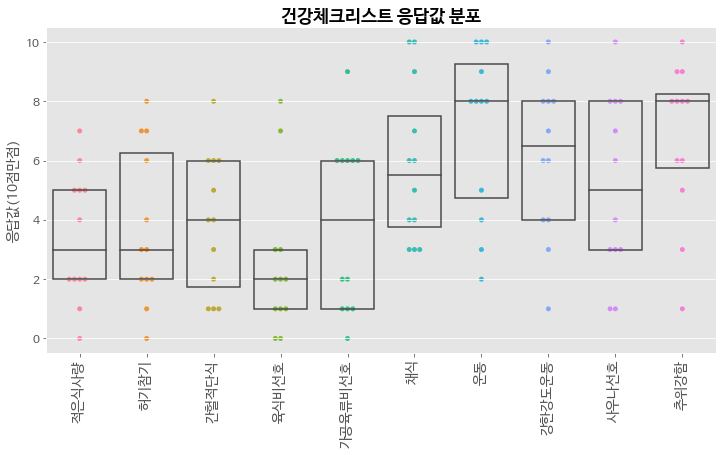

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.swarmplot(x="question", y="answer", data=df_stack, zorder=0)
sns.boxplot(x="question", y="answer", data=df_stack, 
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':0}, ax=ax)
plt.title("건강체크리스트 응답값 분포", fontsize=18, fontweight='bold')
plt.xlabel("")
plt.ylabel("응답값(10점만점)", fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=12)
plt.show()

### 분석#2. 군집분석, 히트맵 차트

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


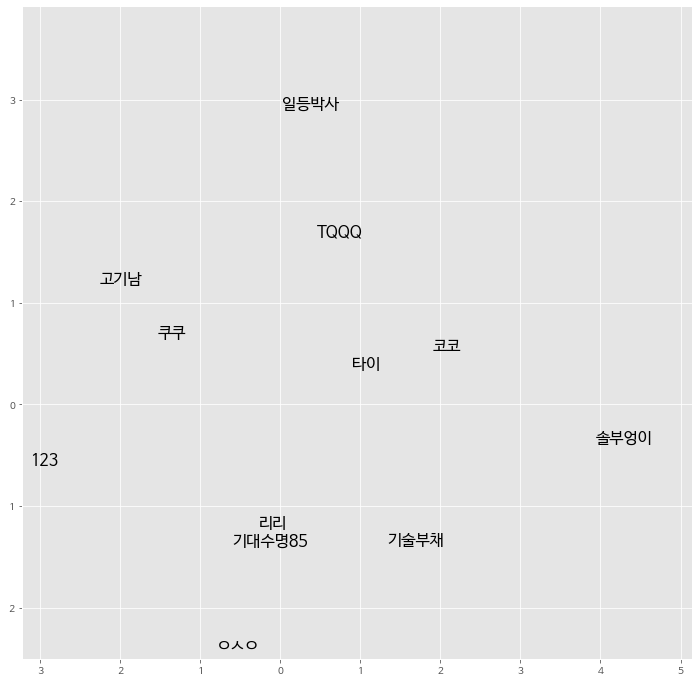

In [ ]:
from sklearn.preprocessing import StandardScaler     
from sklearn.decomposition import PCA               

X = df_survey.iloc[:, :10].values 
targets = df_survey['nickname']

X_norm = StandardScaler().fit(X).transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit(X_norm).transform(X_norm)

xmax, ymax = np.amax(X_pca, axis=0)
xmin, ymin = np.amin(X_pca, axis=0)

plt.figure(figsize=(12,12))
for i in range(len(X_pca)):
  x = X_pca[i,0]
  y = X_pca[i,1]
  t = targets[i] 
  plt.text(x, y, t, fontsize=16)
  
# 최대값, 최소값에서 공간 더 마련하기
plt.xlim(xmin-0.1, xmax+1.2)
plt.ylim(ymin-0.1, ymax+1)
plt.show()

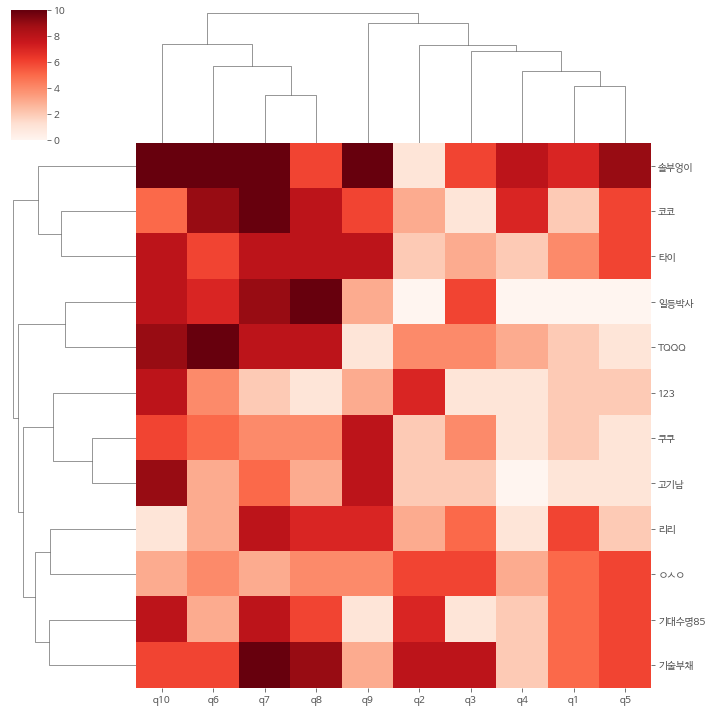

In [ ]:
g = sns.clustermap(df_survey.iloc[:, :10], 
                   yticklabels=df_survey['nickname'],
                   cmap='Reds')